In [1]:

import librosa
import numpy as np
from scipy.signal import lfilter, butter
import decimal
import math
import logging
import scipy.io as sio
import keras.backend as K
from keras.layers import Input, GlobalAveragePooling2D, Reshape,Flatten,Dense
from keras.layers.convolutional import Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Lambda, Activation
from keras.models import Model
from keras.models import load_model
import os
import pandas as pd
from scipy.spatial.distance import cdist, euclidean, cosine
from glob import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import shutil
from tqdm import tqdm
import csv
import random
from statistics import mean
import copy
import numpy as np
import tensorflow as tf
from tensorflow import contrib as loss_metric

Using TensorFlow backend.


## Loading Data

In [2]:
speakers, n = np.load('details.npy',allow_pickle=True)

In [3]:
training_samples = np.load('training_samples.npy', allow_pickle=True).tolist()
testing_samples = np.load('testing_samples.npy', allow_pickle=True).tolist()

Text(0, 0.5, 'Frequency')

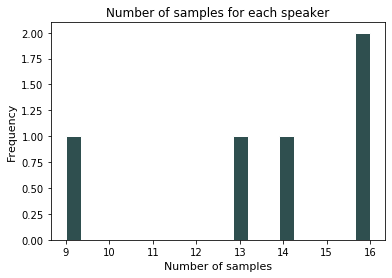

In [4]:
samples_number = [len(i) for i in training_samples]
total_samples = sum(samples_number)
# Draw the plot
plt.hist(samples_number,bins = 20,color = '#2F4F4F', edgecolor = 'w')    
# Title and labels
plt.title('Number of samples for each speaker')
plt.xlabel('Number of samples', size = 11)
plt.ylabel('Frequency', size= 11)

## Forming Triplets

In [5]:
def generate_triplets(data):
    data_copy_1 = copy.deepcopy(data)
    data_copy = copy.deepcopy(data)
    triplets = []
    for speaker in range(n):
        for audio in data_copy_1[speaker]:
            data_copy = copy.deepcopy(data)
            triplet = [audio]
            data_copy[speaker].remove(audio)
            random.shuffle(data_copy[speaker])
            triplet.append(data_copy[speaker].pop(0))
            del data_copy[speaker]
            negative_id = random.randint(0, len(data_copy)-1)
            random.shuffle(data_copy[negative_id])
            triplet.append(data_copy[negative_id].pop(0))
            triplets.append(triplet)
        
    return triplets
    
label_data = copy.deepcopy(training_samples)
triplets_data = generate_triplets(label_data)

In [6]:
check = 0
for i in triplets_data:
    if (i[0][1] == i[1][1]) and (i[0][1] != i[2][1]):
        check +=1
total_samples == len(triplets_data) == check

True

## Constants

In [7]:

SAMPLE_RATE = 16000
PREEMPHASIS_ALPHA = 0.97
FRAME_LEN = 0.025
FRAME_STEP = 0.01
NUM_FFT = 512
BUCKET_STEP = 1
MAX_SEC = 3

WEIGHTS_FILE = "SavedModel/weights.h5"
# COST_METRIC = "cosine" 
INPUT_SHAPE=(NUM_FFT,300,1)


DURATION = []

## Representation of Audio Data (Speech to Spectrum)

In [8]:
# https://github.com/jameslyons/python_speech_features
# This file includes routines for basic signal processing including framing and computing power spectra.
# Author: James Lyons 2012


def load_wav(filename, sample_rate):
    audio, sr = librosa.load(filename, sr=sample_rate, mono=True)
    audio_length = librosa.get_duration(audio,sr=sr)
    DURATION.append(audio_length)
    audio = audio.flatten()    
    return audio

# https://github.com/christianvazquez7/ivector/blob/master/MSRIT/rm_dc_n_dither.m
def remove_dc_and_dither(sin, sample_rate):
    if sample_rate == 16e3:
        alpha = 0.99
    elif sample_rate == 8e3:
        alpha = 0.999
    sin = lfilter([1,-1], [1,-alpha], sin)
    dither = np.random.random_sample(len(sin)) + np.random.random_sample(len(sin)) - 1
    spow = np.std(dither)
    sout = sin + 1e-6 * spow * dither
    return sout

def preemphasis(signal, coeff=0.95):
    return np.append(signal[0], signal[1:] - coeff * signal[:-1])

def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

def rolling_window(a, window, step=1):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)[::step]


def framesig(sig, frame_len, frame_step, winfunc=lambda x: np.ones((x,)), stride_trick=True):
    
    slen = len(sig)
    frame_len = int(round_half_up(frame_len))
    frame_step = int(round_half_up(frame_step))
    if slen <= frame_len:
        numframes = 1
    else:
        numframes = 1 + int(math.ceil((1.0 * slen - frame_len) / frame_step)) # LV

    padlen = int((numframes - 1) * frame_step + frame_len)

    zeros = np.zeros((padlen - slen,))
    padsignal = np.concatenate((sig, zeros))
    win = winfunc(frame_len)
    frames = rolling_window(padsignal, window=frame_len, step=frame_step)
    
    return frames * win


def normalize_frames(m,epsilon=1e-12):
    return np.array([(v - np.mean(v)) / max(np.std(v),epsilon) for v in m])

def get_fft_spectrum(filename, buckets):
    signal = load_wav(filename,SAMPLE_RATE)
    signal *= 2**15

    # get FFT spectrum
    signal = remove_dc_and_dither(signal, SAMPLE_RATE)
    signal = preemphasis(signal, coeff=PREEMPHASIS_ALPHA)
    frames = framesig(signal, frame_len=FRAME_LEN*SAMPLE_RATE, frame_step=FRAME_STEP*SAMPLE_RATE, winfunc=np.hamming)
    fft = abs(np.fft.fft(frames,n=NUM_FFT))
    fft_norm = normalize_frames(fft.T)

    # truncate to max bucket sizes
    rsize = max(k for k in buckets if k <= fft_norm.shape[1])
    rstart = int((fft_norm.shape[1]-rsize)/2)
    out = fft_norm[:,rstart:rstart+rsize]

    return out


## Pre-Trained Model

In [9]:

# Block of layers: Conv --> BatchNorm --> ReLU --> Pool
def conv_bn_act_pool(inp_tensor,layer_idx,conv_filters,conv_kernel_size,conv_strides,conv_pad,
    pool='',pool_size=(2, 2),pool_strides=None,
    conv_layer_prefix='conv'):
    x = ZeroPadding2D(padding=conv_pad,name='pad{}'.format(layer_idx))(inp_tensor)
    x = Conv2D(filters=conv_filters,kernel_size=conv_kernel_size, strides=conv_strides, padding='valid', name='{}{}'.format(conv_layer_prefix,layer_idx))(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1,name='bn{}'.format(layer_idx))(x)
    x = Activation('relu', name='relu{}'.format(layer_idx))(x)
    if pool == 'max':
        x = MaxPooling2D(pool_size=pool_size,strides=pool_strides,name='mpool{}'.format(layer_idx))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=pool_size,strides=pool_strides,name='apool{}'.format(layer_idx))(x)
    return x


# Block of layers: Conv --> BatchNorm --> ReLU --> Dynamic average pool (fc6 -> apool6 only)
def conv_bn_dynamic_apool(inp_tensor,layer_idx,conv_filters,conv_kernel_size,conv_strides,conv_pad,
    conv_layer_prefix='conv'):
    x = ZeroPadding2D(padding=conv_pad,name='pad{}'.format(layer_idx))(inp_tensor)
    x = Conv2D(filters=conv_filters,kernel_size=conv_kernel_size, strides=conv_strides, padding='valid', name='{}{}'.format(conv_layer_prefix,layer_idx))(x)
    x = BatchNormalization(epsilon=1e-5,momentum=1,name='bn{}'.format(layer_idx))(x)
    x = Activation('relu', name='relu{}'.format(layer_idx))(x)
    x = GlobalAveragePooling2D(name='gapool{}'.format(layer_idx))(x)
    x = Reshape((1,1,conv_filters),name='reshape{}'.format(layer_idx))(x)
    return x


# VGGVox verification model
def vggvox_model():
    inp = Input(INPUT_SHAPE,name='input')
    x = conv_bn_act_pool(inp,layer_idx=1,conv_filters=96,conv_kernel_size=(7,7),conv_strides=(2,2),conv_pad=(1,1),
        pool='max',pool_size=(3,3),pool_strides=(2,2))
    x = conv_bn_act_pool(x,layer_idx=2,conv_filters=256,conv_kernel_size=(5,5),conv_strides=(2,2),conv_pad=(1,1),
        pool='max',pool_size=(3,3),pool_strides=(2,2))
    x = conv_bn_act_pool(x,layer_idx=3,conv_filters=384,conv_kernel_size=(3,3),conv_strides=(1,1),conv_pad=(1,1))
    x = conv_bn_act_pool(x,layer_idx=4,conv_filters=256,conv_kernel_size=(3,3),conv_strides=(1,1),conv_pad=(1,1))
    x = conv_bn_act_pool(x,layer_idx=5,conv_filters=256,conv_kernel_size=(3,3),conv_strides=(1,1),conv_pad=(1,1),
        pool='max',pool_size=(5,3),pool_strides=(3,2))
    x = conv_bn_dynamic_apool(x,layer_idx=6,conv_filters=4096,conv_kernel_size=(9,1),conv_strides=(1,1),conv_pad=(0,0),
        conv_layer_prefix='fc')
    x = conv_bn_act_pool(x,layer_idx=7,conv_filters=1024,conv_kernel_size=(1,1),conv_strides=(1,1),conv_pad=(0,0),
        conv_layer_prefix='fc')
    x = Lambda(lambda y: K.l2_normalize(y, axis=3), name='norm')(x)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid', name='fc8')(x)
    m = Model(inp, x, name='VGGVox')
    return m



## Triplet Loss Model

In [10]:
       
# base_model = vggvox_model()
# print('Loading Weights...')
# base_model.load_weights(WEIGHTS_FILE)

# x = base_model.layers[-6].output
# x = conv_bn_act_pool(x,layer_idx=9,conv_filters=2048,conv_kernel_size=(1,1),conv_strides=(1,1),conv_pad=(0,0),
#         conv_layer_prefix='fc')
# x = conv_bn_act_pool(x,layer_idx=10,conv_filters=1024,conv_kernel_size=(1,1),conv_strides=(1,1),conv_pad=(0,0),
#         conv_layer_prefix='fc')
# x = Lambda(lambda y: K.l2_normalize(y, axis=3), name='norm2')(x)
# feature_vector = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid', name='feature')(x)

# encoder = Model(inputs=base_model.input, outputs=feature_vector)
# # for i,layer in enumerate(encoder.layers):
# #     print(i,layer.name)
# # encoder.summary()
# for layer in encoder.layers[:26]:
#     layer.trainable=False
# print('Encoder built!')


In [11]:
def encoder(INPUT_SHAPE):
    base_model = vggvox_model()
    print('Loading Weights...')
    base_model.load_weights(WEIGHTS_FILE)

    x = base_model.layers[-6].output
    x = conv_bn_act_pool(x,layer_idx=9,conv_filters=2048,conv_kernel_size=(1,1),conv_strides=(1,1),conv_pad=(0,0),
            conv_layer_prefix='fc')
    x = conv_bn_act_pool(x,layer_idx=10,conv_filters=1024,conv_kernel_size=(1,1),conv_strides=(1,1),conv_pad=(0,0),
            conv_layer_prefix='fc')
    x = Lambda(lambda y: K.l2_normalize(y, axis=3), name='norm2')(x)
    x = Conv2D(filters=1024,kernel_size=(1,1), strides=(1,1), padding='valid', name='feature')(x)
    feature_vector = Flatten()(x)
    encoder = Model(inputs=base_model.input, outputs=feature_vector)
#     return encoder.layers[-1].output
    return feature_vector


In [12]:
def build_network(encoder,input_shape_1,input_shape_2,input_shape_3):
       
    input_1 = Input(input_shape_1)
    input_2 = Input(input_shape_2)
    input_3 = Input(input_shape_3)
    
    anchor = encoder(input_1)
    positive = encoder(input_2)
    negative = encoder(input_3)
    
    model_ = Model(inputs=[input_1, input_2,input_3], outputs=[anchor,positive,negative])

    return model_

In [13]:
def triplet_loss(y_true,y_pred,alpha=0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    
    #Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    #Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
  


    return basic_loss  
  

In [15]:
triplet_loss_model = build_network(encoder,INPUT_SHAPE,INPUT_SHAPE,INPUT_SHAPE)

In [16]:
triplet_loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 1024)   23993024    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

## Preparing Training Data

In [19]:
def build_buckets(max_sec, step_sec, frame_step):
    buckets = {}
    frames_per_sec = int(1/frame_step)
    end_frame = int(max_sec*frames_per_sec)
    step_frame = int(step_sec*frames_per_sec)
    for i in range(0, end_frame+1, step_frame):
        s = i
        s = np.floor((s-7+2)/2) + 1  # conv1
        s = np.floor((s-3)/2) + 1  # mpool1
        s = np.floor((s-5+2)/2) + 1  # conv2
        s = np.floor((s-3)/2) + 1  # mpool2
        s = np.floor((s-3+2)/1) + 1  # conv3
        s = np.floor((s-3+2)/1) + 1  # conv4
        s = np.floor((s-3+2)/1) + 1  # conv5
        s = np.floor((s-3)/2) + 1  # mpool5
        s = np.floor((s-1)/1) + 1  # fc6
        s = np.floor((s-1)/1) + 1  
        s = np.floor((s-1)/1) + 1  
        s = np.floor((s-1)/1) + 1  
        if s > 0:
            buckets[i] = int(s)
    return buckets

buckets = build_buckets(MAX_SEC, BUCKET_STEP, FRAME_STEP)

In [20]:
emb_header = ['SampleName','Embedding']
embeddings_df = pd.DataFrame(columns=emb_header)
training_data = [item for sublist in training_samples for item in sublist]
for i in training_data:
    path = i[0]
    embedding = get_fft_spectrum(i[0], buckets).tolist()
    embeddings_df = embeddings_df.append({'SampleName': path, 'Embedding': embedding}, ignore_index=True)
# embeddings_df = embeddings_df.set_index('SampleName')
embeddings_df.head()

SampleName                                          Embedding
0  Dataset-50/id10001.1.wav  [[-0.17347658371073954, -0.6209549944287784, -...
1  Dataset-50/id10001.2.wav  [[-0.20910647348944567, -0.514774975877926, -0...
2  Dataset-50/id10001.3.wav  [[-0.9298623376418144, 0.1429183712619456, 0.1...
3  Dataset-50/id10001.4.wav  [[0.14234187949768848, -0.536273735213763, -0....
4  Dataset-50/id10001.5.wav  [[-0.7874616403189847, -0.3218853683948591, 3....

In [21]:
train_header = ['ID_anchor','emb_anchor','ID_positive','emb_positive','ID_negative','emb_negative']

In [22]:
def get_audio_embeddings(triplets):
    with open('train_triplet_loss.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=train_header)
        writer.writeheader()
        for triplet in triplets:
            row = []
            row.append(triplet[0][1])
            row.append(triplet[0][0])
            row.append(triplet[1][1])
            row.append(triplet[1][0])
            row.append(triplet[2][1])
            row.append(triplet[2][0])            
            writer.writerow(dict(zip(train_header, row)))
            
    train_df = pd.read_csv('train_triplet_loss.csv')    
    return train_df['emb_anchor'],train_df['emb_positive'],train_df['emb_negative']

In [23]:
X_A,X_P,X_N = get_audio_embeddings(triplets_data)

In [24]:
train_df = pd.read_csv('train_triplet_loss.csv')    
train_df.head()

ID_anchor                emb_anchor  ID_positive              emb_positive  \
0          0  Dataset-50/id10001.1.wav            0  Dataset-50/id10001.4.wav   
1          0  Dataset-50/id10001.2.wav            0  Dataset-50/id10001.8.wav   
2          0  Dataset-50/id10001.3.wav            0  Dataset-50/id10001.7.wav   
3          0  Dataset-50/id10001.4.wav            0  Dataset-50/id10001.2.wav   
4          0  Dataset-50/id10001.5.wav            0  Dataset-50/id10001.3.wav   

   ID_negative               emb_negative  
0           18  Dataset-50/id10019.12.wav  
1            6   Dataset-50/id10007.3.wav  
2            4   Dataset-50/id10005.9.wav  
3           26   Dataset-50/id10027.5.wav  
4           23   Dataset-50/id10024.5.wav

In [31]:
triplet_len = len(triplets_data)
Y = [np.random.rand(1024,).reshape(-1,1024,) for i in range(triplet_len)]
y = [np.array(Y),np.array(Y),np.array(Y)]
buckets = build_buckets(MAX_SEC, BUCKET_STEP, FRAME_STEP)
X_A_emb = list(train_df['emb_anchor'].map(embeddings_df.set_index('SampleName')['Embedding']))
X_P_emb = list(train_df['emb_positive'].map(embeddings_df.set_index('SampleName')['Embedding']))
X_N_emb = list(train_df['emb_negative'].map(embeddings_df.set_index('SampleName')['Embedding']))

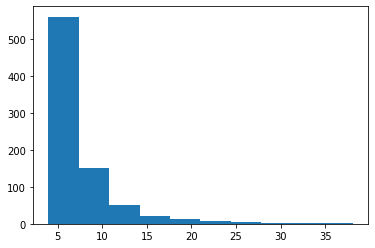

In [32]:
plt.hist(DURATION,bins=10)
plt.show()

In [33]:
print('Min Duration:',min(DURATION),'   Avg Duration:',sum(DURATION)/len(DURATION),'   Max Duration:',max(DURATION))

Min Duration: 3.9600625    Avg Duration: 7.332938876988976    Max Duration: 38.0800625


In [34]:
#Compilation
triplet_loss_model.compile(optimizer ='adam',loss=triplet_loss)

In [35]:
triplet_loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 300, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1, 1, 1024)   23993024    input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [37]:
triplet_loss_model.fit([np.array(X_A_emb).reshape(-1,512,300,1), np.array(X_P_emb).reshape(-1,512,300,1), np.array(X_N_emb).reshape(-1,512,300,1)],[y[0],y[1],y[2]],epochs=1)

In [216]:
triplet_loss_model.save('try_model.h5')

## Testing Data

In [217]:
testing_samples[1:][:3]

[['Dataset-50/id10001.0.wav', 'id10001'],
 ['Dataset-50/id10002.0.wav', 'id10002'],
 ['Dataset-50/id10003.0.wav', 'id10003']]

In [38]:
try_model = load_model('try_model.h5', custom_objects={'triplet_loss':triplet_loss})

In [51]:
embeddings_df.head()

SampleName                                          Embedding
0  Dataset-50/id10001.1.wav  [[-0.17347658371073954, -0.6209549944287784, -...
1  Dataset-50/id10001.2.wav  [[-0.20910647348944567, -0.514774975877926, -0...
2  Dataset-50/id10001.3.wav  [[-0.9298623376418144, 0.1429183712619456, 0.1...
3  Dataset-50/id10001.4.wav  [[0.14234187949768848, -0.536273735213763, -0....
4  Dataset-50/id10001.5.wav  [[-0.7874616403189847, -0.3218853683948591, 3....

In [55]:
list(embeddings_df[embeddings_df['SampleName']=='Dataset-50/id10001.1.wav']['Embedding'])

[[[-0.17347658371073954,
   -0.6209549944287784,
   -0.4870946917213302,
   -1.1048895518579216,
   -1.0164977065683434,
   -0.2794792592349092,
   -0.18519039449636818,
   0.39270915438856113,
   1.3077857602933496,
   -0.25344058849494594,
   -0.5459249573786654,
   -0.207093217403535,
   0.35793996320857135,
   0.025283937906375977,
   -0.2568250730503701,
   -0.6301319894586203,
   1.8436141422850667,
   -0.6248980622718323,
   -0.7704492321452371,
   -0.5915430250478579,
   1.8948212783233793,
   0.08479347966288632,
   -0.8748807289820609,
   -0.7581166134215743,
   1.1478779607128875,
   -0.42180769621093084,
   0.11243600566148995,
   0.11873686677717356,
   1.1091688077645143,
   -0.7614164592911706,
   0.996447793634844,
   0.17123110247557077,
   2.4928683266649183,
   1.1808092059236284,
   0.05217986468626578,
   2.707108596688216,
   -0.04334754595824013,
   -0.9101968034399457,
   0.29770691914662684,
   -0.1772254984713697,
   -1.116527765244994,
   0.7313966938811631,


In [41]:
def triplet_loss_prediction(y_true,y_pred,alpha=0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    
    #Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)))
    #Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)))
    #Subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    return tf.to_float(basic_loss)

def generate_triplets_prediction(data,new_data):
    triplets = []
    for i in range(n):
        data_copy = copy.deepcopy(data)
        negatives = []
        triplet = []
        for j in range(3):
            random.shuffle(data_copy[i])
            triplet.append([new_data,data_copy[i].pop(0)])
        del data_copy[i]
        flatten_data = [item for sublist in data_copy for item in sublist]
        random.shuffle(flatten_data)
        for ap_pair in triplet:
            ap_pair.append(flatten_data.pop(0))
        triplets.extend(triplet)
    return triplets

In [62]:
def predict_speaker(sample):
    data = copy.deepcopy(training_samples)
    triplets = generate_triplets_prediction(data,sample)
    minimum_loss = float(1000)
    true_label = -1
    model = try_model
    a = get_fft_spectrum(sample, buckets)
    for triplet in triplets:        
        p = get_fft_spectrum(triplet[1][0], buckets)
        n = get_fft_spectrum(triplet[2][0], buckets)
        y_pred = model.predict([np.array(a).reshape(-1,512,300,1),np.array(p).reshape(-1,512,300,1),np.array(n).reshape(-1,512,300,1)])
        y_true = 0
        label = triplet[1][1]
        loss = triplet_loss_prediction(y_true,y_pred,alpha=0.2)
        if tf.keras.backend.get_value(loss) < minimum_loss:
            minimum_loss = tf.keras.backend.get_value(loss)
            true_label = label
    
    print('Predicted speaker: ', speakers[true_label])

In [63]:
predict_speaker('Dataset-50/id10001.0.wav')

In [66]:
def predict_speaker_batch(model,samples):
    result = []
    for sample in samples:
        data = copy.deepcopy(training_samples)
        triplets = generate_triplets_prediction(data,sample)
        minimum_loss = float(1000)
        true_label = -1
        a = get_fft_spectrum(sample, buckets)
        for triplet in triplets:
           
            p = get_fft_spectrum(triplet[1][0], buckets)
            n = get_fft_spectrum(triplet[2][0], buckets)
            y_pred = model.predict([np.array(a).reshape(-1,512,300,1),np.array(p).reshape(-1,512,300,1),np.array(n).reshape(-1,512,300,1)])
            y_true = 0
            label = triplet[1][1]
            loss = triplet_loss_prediction(y_true,y_pred,alpha=0.2)
            if tf.keras.backend.get_value(loss) < minimum_loss:
                minimum_loss = tf.keras.backend.get_value(loss)
                true_label = label
        result.append(true_label)
    return result
    

In [ ]:
samples = [i[0] for i in testing_samples[1:11]]
predictions = predict_speaker_batch(try_model,samples)
true_values = [i[1] for i in testing_samples[1:11]]

c:\users\lenovo\desktop\speakeridentification\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
